# Molecular Dynamics of A Lennard Jones Fluid #

This jupyter notebook loosely follows Chapter 4 of *Understanding Molecular Simulation: From Algorithms to Applications* by Daan Frenkel and Berend Smit:

Frenkel, D.; Smit, B. Chapter 4: Molecular Dynamics Simulations. In *Understanding Molecular Simulation: From Algorithms to Applications*; Computational Science Series, Vol. 1; Frenkel, D., Klein, M., Parrinello, M., Smit, B., Eds.; Academic Press, 2002; pp 63-107. ISBN 0-12-267351-4.

## Necessary Packages ##

In [19]:
%load_ext cython

import numpy as np # Arrays make the math so much faster
import matplotlib.pyplot as plt # For plotting
from matplotlib.ticker import FixedLocator, MaxNLocator, AutoMinorLocator # For setting locations of x and y ticks on plots
import matplotlib.animation as animation # For Lennard Jones Demo
from matplotlib.patches import Circle
from tqdm.notebook import tqdm # A very handy progress bar
from IPython.display import HTML
from numba import njit

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


## Parameters ##
Keep in mind that we will operate in reduced (i.e. dimensionless) units throughout this calculation. Here, we provide the parameters with their units and convert them into their reduced form. The output is going to need to be converted back to units with dimensions so that they will make sense. Operating in reduced units will allow us to greatly simplify the equations, making our code more scalable. While this may not be entirely necessary for the small systems we will simulate here, it is good practice as reduced units are commonplace in molecular dynamics.

Here are the conversions:
| Unit | Symbol | Reduced Form |
| --- | --- | --- |
| Length | $r^{*}$ | $r/\sigma$ |
| Time | $t^{*}$ | $t\sqrt{\frac{\epsilon}{m\sigma^2}}$ |
| Temperature | $T^{*}$ | $\frac{k_BT}{\epsilon}$ |
| Force | $F^{*}$ | $\frac{F\sigma}{\epsilon}$ |
| Energy | $U^{*}$ | $\frac{U}{\epsilon}$ |
| Pressure | $p^{*}$ | $\frac{p\sigma^3}{\epsilon}$ |
| Density | $\rho^{*}$ | $\rho\sigma^3$ |
| Surface Tension | $\gamma^{*}$ | $\frac{\gamma\sigma^2}{\epsilon}$ |

Typically, people perform the Lennard Jones simulation using liquid argon. You can of course do something different if you would like, but for your reference: $\sigma_{Ar}=3.405 \mathring A$, $\epsilon_{Ar}=0.238 \; \mathrm{kcal} \; \mathrm{mol^{-1}}$, and $m = 0.03994 \; \mathrm{kg} \; \mathrm{mol^{-1}}$. You also need to set a temperature and a density. A common temperature used for this simulation is $\mathrm{120 \; K}$ (in reduced units this is $\mathrm{\sim 1}$). At this temperature, the density of saturated liquid argon is $\mathrm{0.029027 \; mol \; cm^{-3}}$.

In [20]:
# SYSTEM SETTINGS
# Number of Particles (Must be able to take a cubed root evenly, i.e. n_particles^(1/3)%1 = 0), Type: Int
n_particles = 216

# Temperature in Kelvin, Type: Float
temp = 120.0

# Density in mol/cm^3, Type: Float
density = 0.0291

# SIMULATION SETTINGS
# Time Step in ps, Type: Float
time_step = 0.002

# Total number of equilibration steps to take using velocity rescaling, Type: Int
length_of_equilibration = 1000

# Total Number of Steps to Take in Simulation, Type: Int
length_of_simulation = 10000

# Writing Frequency (how often to write positions, energies, etc.), Type: Int
write_freq = 1

# PARTICLE SETTINGS
# Lennard Jones Sigma in Angstroms, Type: Float
sigma = 3.405

# Lennard Jons Epsilon in kcal/mol, Type: Float
epsilon = 0.238

# Mass in kg/mol, Type: Float
mass = 0.03994

# Namestem for written files.
# e.g. if "LJFluid", files will be named "LJFluid_positions.xyz", "LJFluid_energies.ene", etc.
#      if empty string ("") or None, files will be named "positions.xyz", "energies.ene", etc.
file_namestem = None

In [21]:
def handle_inputs(n_particles, temp, density, time_step, length_of_equilibration, length_of_simulation, 
                  write_freq, sigma, epsilon, mass, file_namestem):
    '''
    Convert inputs to reduced units as necessary and make sure are correct

    Parameters
    ----------
    n_particles : int
        The number of particles
    temp : float
        The temperature in K
    density : float
        The density in mol/cm^3
    time_step : float
        The time step in ps
    length_of_equilibration : int
        The number of equilibration steps to make
    length_of_simulation : int
        The number of simulation steps to make
    write_freq : int
        The frequency to write to the output files in number of steps
    sigma : float
        The Lennard Jones sigma parameter in Angstroms
    epsilon : float
        The Lennard Jones epsilon parameter in kcal/mol
    mass : float
        The atomic mass in kg/mol
    file_namestem : str
        The namestem of the output files. e.g. if "LJFluid", files will be 
        named "LJFluid_positions.xyz", "LJFluid_energies.ene", etc. if 
        empty string ("") or None, files will be named "positions.xyz", 
        "energies.ene", etc.
    
    Returns
    -------
    temp : float
        The temperature in reduced units
    time_step : float
        The time step in reduced units
    file_namestem : float
        The corrected namestem
    '''
    # Convert Temperature
    red_temp = temp * 0.001987204259 / epsilon # T* = T*(k_B/epsilon)

    # Convert Times
    red_time_step = time_step * np.sqrt(epsilon/(mass * sigma**2)) # t* = t*sqrt(epsilon/(m*sigma^2))

    # Adjust Namestem
    if file_namestem != "" and file_namestem is not None and file_namestem[-1] != "_":
        file_namestem = file_namestem + "_"
    elif file_namestem is None:
        file_namestem = ""

    # Check validity of n_particles
    if (n_particles**(1/3))<int(n_particles**(1/3)):
        print(f"Error: You must be able to take the cubed root of n_particles evenly, but {n_particles}^(1/3)={n_particles**(1/3)}. Examples of valid choices are 8, 27, 216, etc.")
        del n_particles
    else:
        print(f"""            Input Parameters
            ----------------
            Number of Particles = {n_particles}
                    Temperature = {temp} K (T* = {red_temp})
                        Density = {density} mol/cm^3
                      Time Step = {time_step} ps (dt* = {red_time_step})
        Length of Equilibration = {length_of_equilibration} steps (time = {length_of_equilibration*time_step} ps)
           Length of Simulation = {length_of_simulation} steps (time = {length_of_simulation*time_step} ps)
              Writing Frequency = {write_freq} steps
                          Sigma = {sigma} Angstroms
                        Epsilon = {epsilon} kcal/mol
                           Mass = {mass} kg/mol

            Output Files
            ------------
            PBC-corrected positions: {file_namestem}positions.xyz
                      Raw positions: {file_namestem}unwrapped_positions.xyz
                         Velocities: {file_namestem}velocities.xyz
                             Forces: {file_namestem}velocities.xyz
                           Energies: {file_namestem}velocities.xyz
        """)
    temp = red_temp 
    time_step = red_time_step
    return temp, time_step, file_namestem
temp, time_step, file_namestem = handle_inputs(n_particles, temp, density, time_step, length_of_equilibration,
                                               length_of_simulation, write_freq, sigma, epsilon, mass, file_namestem)

            Input Parameters
            ----------------
            Number of Particles = 216
                    Temperature = 120.0 K (T* = 1.0019517272268907)
                        Density = 0.0291 mol/cm^3
                      Time Step = 0.002 ps (dt* = 0.0014338288933164458)
        Length of Equilibration = 1000 steps (time = 2.0 ps)
           Length of Simulation = 10000 steps (time = 20.0 ps)
              Writing Frequency = 1 steps
                          Sigma = 3.405 Angstroms
                        Epsilon = 0.238 kcal/mol
                           Mass = 0.03994 kg/mol

            Output Files
            ------------
            PBC-corrected positions: positions.xyz
                      Raw positions: unwrapped_positions.xyz
                         Velocities: velocities.xyz
                             Forces: velocities.xyz
                           Energies: velocities.xyz
        


## The Initialization ##
### Generate Initial Positions ###
There are many ways we could initialize the system. In this case (perhaps the simplest) we set the number of particles and density and use those parameters to determine the properly sized cubic box to fit them. You could also, however, choose the box size and density and fill the box with however many particles are needed. You could even make the box non-cubic, but that would complicate the treatment of periodic boundary conditions.

We can use the NumPy function, [`np.meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), to easily place the particles on a cubic lattice.

In [22]:
def fill_box(n_particles, density, sigma):
    '''
    Create a box full of equally spaced atoms

    Parameters
    ----------
    n_particles : int
        The number of particles to place in the box
    density : float
        The density of the particles in the box
    sigma : float
        The lennard-jones sigma parameter
    
    Returns
    -------
    positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The initial positions of the particles
    box_length : float
        The length of the box
    positions_per_dim : int
        The number of positions included per dimension
    '''
    # Convert Density to Atoms/Angstrom^3
    density = density * 0.602214076 # Atoms/Angstrom^3 = mol/cm^3 * 6.02214076e23 1/mol * (1e-8 cm/Angstrom)^3

    # For a cubic box, there will be n_particles**(1/3) rows of particles in each dimension:
    positions_per_dim = int(np.round(n_particles ** (1/3)))
    
    # The box length will be (n_particles/density)**(1/3) [here we reuse positions_per_dim]:
    box_length = (positions_per_dim / (density ** (1/3)))/sigma

    print(f"""
            Box Length = {box_length*sigma:.3f} Angstroms
        """)
    
    # Find equally spaced positions for the particles along each dimesion:
    dim_positions, spacing = np.linspace(0, box_length, positions_per_dim, endpoint=False, retstep=True)
    dim_positions = dim_positions + spacing/2 # Center in box
    
    # Create a 3D grid using those positions and then collapse it into a (n_particles, 3) shaped array:
    X, Y, Z = np.meshgrid(dim_positions, dim_positions, dim_positions)
    positions = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
    
    return positions, box_length, positions_per_dim
  
positions, box_length, positions_per_dim = fill_box(n_particles, density, sigma)


            Box Length = 23.100 Angstroms
        


### Generate Initial Velocities ###
We generate initial velocities using a NumPy's random number generator. Importantly, these random velocities might result in net movement of the system in one direction. We need to correct this drift prior to starting the simulation. 

In [23]:
def rescale_velocities(velocities, temp):
    '''
    Rescale velocities to maintain set temperature

    Parameters
    ----------
    velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The unscaled velocities of the particles
    temp : float
        The set temperature of the system
    
    Return
    ------
    velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The rescaled velocities of the particles
    '''
    # calculate the box drift
    xyz_drift = np.sum(velocities, axis=0)/velocities.shape[0]
    tot_drift = np.sum(velocities**2)/velocities.shape[0] 
    
    # scaling factor to correct velocities
    scale = np.sqrt(3*temp/tot_drift) # was np.sqrt((temp*3)/tot_drift)

    # correct velocities with scaling factor
    velocities = (velocities - xyz_drift)*scale

    return velocities

def initialize_velocities(positions, temp, time_step):
    '''
    Gather initial velocities for each particle

    Parameters
    ----------
    positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The initial positions of the particles
    temp : float
        The temperature
    time_step : int
        The time step of the simulation
    
    Returns
    -------
    velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The initial velocities of the particles
    '''
    # generate random velocity vectors for each particle (between -0.5 and 0.5)
    velocities = np.random.normal(size=positions.shape)
    
    # rescale velocities to match set temperature
    velocities = rescale_velocities(velocities, temp)

    return velocities

velocities = initialize_velocities(positions, temp, time_step)

### The Initial System ###

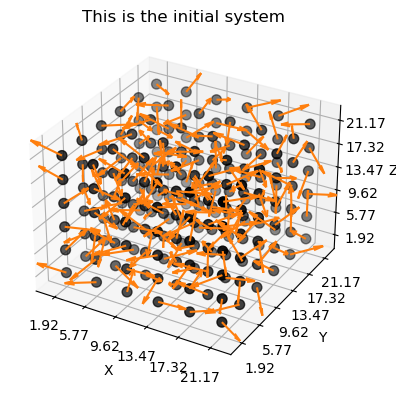

In [24]:
# Plot the positions & velocities
ax = plt.figure(figsize=(4.5, 4.5)).add_subplot(projection='3d')

# Positions
ax.scatter(positions[:,0]*sigma, positions[:,1]*sigma, positions[:,2]*sigma,
           color='black', s=50)

# Velocities
velcf = np.sqrt(sigma/mass)
tickspacing = box_length*sigma / positions_per_dim
ax.quiver(positions[:,0]*sigma, positions[:,1]*sigma, positions[:,2]*sigma, 
          velocities[:,0]*velcf, velocities[:,1]*velcf, velocities[:,2]*velcf, 
          length=tickspacing, color='tab:orange', normalize=True)

ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Z', fontsize=10)
ax.set_xlim(0, box_length*sigma)
ax.set_ylim(0, box_length*sigma)
ax.set_zlim(0, box_length*sigma)

ticks = np.arange(0, positions_per_dim, 1)*tickspacing + tickspacing/2

ax.yaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.zaxis.set_major_locator(FixedLocator(ticks))
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.grid(which='minor')
ax.set_axisbelow(True)
ax.set_title("This is the initial system", fontsize=12)
plt.show()

## The Force Calculation ##

### The Lennard-Jones Potential ###

The Lennard-Jones potential is perhaps the most famous intermolecular pair potential, given by:

$V_{LJ}(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right]$

So, the force between two particles in a given cartesian direction, x, is given by:

$F_x(r) = - \frac{\partial V_{LJ}(r)}{\partial x} = -\frac{x}{r} \left( \frac{\partial V_{LJ}(r)}{\partial r} \right)$

Which, when expressed using reduced units is:

$F_x^*(r^*) = \frac{48r_x^*}{(r^*)^2} \left[ \left(\frac{1}{r^*} \right)^{12} -0.5\left(\frac{1}{r^*}\right)^6 \right]$

Similarly, the potential function can be written in terms of reduced units:

$V_{LJ}^*(r^*) = 4\left[ \left( \frac{1}{r^*} \right)^{12} - \left( \frac{1}{r^*} \right)^{6} \right]$

If we graph the potential well, this should look familiar. At long distances the potential energy due to forces between a pair of atoms go to zero. As the approach one another, the potential drops below zero (indicating that there are attractive forces between the atoms), and as the atoms get so close they begin to overlap the potential energy shoots up to infinity.

In [25]:
%%capture
def LJgraph():
    def _LJ(x):
        return 4*0.238*(((3.405/x)**12)-((3.405/x)**6))
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 4.5), gridspec_kw=dict(hspace=0, height_ratios=(2, 3)), sharex=True)
    fig.subplots_adjust(left=0.2, right=0.85, top=1)
    x = np.linspace(3,10,100)
    xx = np.hstack((x, np.flip(x)))
    y = _LJ(x)
    yy = np.hstack((y, np.flip(y)))

    ax[1].axhline(0, color="k")
    ax[1].plot(x, y, color="tab:blue")
    potscat = ax[1].scatter(xx[-1], yy[-1], color="tab:orange", zorder=4)
    ax[1].set_xlabel("r")
    ax[1].set_ylabel(r"$V_{LJ}(r)$")
    ax[1].set_xlim(0, 10)
    ax[1].set_ylim(-0.3, 1)
    
    ax[0].scatter(0,0,color="k",marker="o",s=20,clip_on=False, zorder=6)
    atom_radius = (3.405*2**(1/6))/2
    ax[0].add_artist(Circle((0, 0), atom_radius, ec="k", fc="tab:blue", clip_on=False))
    atomcirc = ax[0].add_artist(Circle((xx[-0], 0), atom_radius, ec="k", fc="tab:orange", alpha=0.8, clip_on=False))
    atomscat = ax[0].scatter(xx[-1],0, color="k",marker="o",s=20,clip_on=False, zorder=6)
    ax[0].tick_params(axis="both", labelleft=False, left=False, bottom=False, labelbottom=False)
    ax[0].set_xlim(0, 10)
    ax[0].set_ylim(-3.405, 3.405)
    ax[0].set_aspect("equal", adjustable="datalim")
    ax[0].axis("off")
    def _animate(i):
        potscat.set_offsets((xx[-i], yy[-i]))
        atomcirc.set_center((xx[-i], 0))
        atomscat.set_offsets((xx[-i], 0))
        return potscat, atomcirc, atomscat
    
    ani = animation.FuncAnimation(fig, _animate, repeat=False, frames = xx.size-1, interval=50)
    return ani.to_jshtml()
LJanimated = LJgraph()

In [26]:
HTML(LJanimated)

### Periodic Boundary Conditions ###

Periodic boundary conditions are a common practice in many molecular dynamics simulations. The basic idea is this: In a simulation you are simulating a number of atoms/molecules on the order of hundreds, thousands, or if you're particularly ambitions, maybe millions. In an experiment, you're working with a number of atoms/molecules on the order of Avogadro's Number ($6.022\times 10^{23} \frac{1}{\mathrm{mol}}$). So, how do we make our simulation return the same results as the experiment. If we put them in a regular box and made them bounce off the walls, there would be finite-sized effects that would produce artifacts in our results. If we didn't apply any walls, they would quickly diffuse away from one another, providing results somewhat reflective of deep space. Instead, we use periodic boundary conditions to make our small system look more like an infinite system (and we all know that Avogadro's Number is pretty much infinity). 

So how do PBCs work? When an atom passes through the edge of the box, it enters on the opposite side of the box. Similarly, the force between two atoms is calculated as the shortest distance between the two atoms, considering the distances through the periodic boundary conditions. A distance or position, $\vec{x}$, can be adjusted to account for periodic boundary conditions with the following equation:

$$ \vec{x}_{PBC} = \vec{x} - \left(\ell \left\lfloor \frac{\vec{x}}{\ell} \right\rceil\right) $$

where $\vec{x}_{PBC}$ is the adjusted position or distance, $\ell$ is the length of the periodic box, and $\lfloor\cdot\cdot\cdot\rceil$ denotes the rounding to the nearest integer operation.

Let's make a figure showing this.

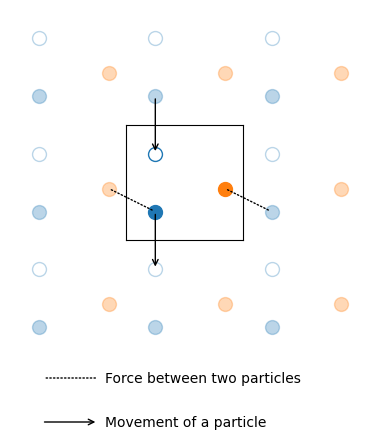

In [27]:
def pbc_figure():
    fig = plt.figure(figsize=(4.5, 5.5))
    gs = fig.add_gridspec(nrows=4, ncols=3, hspace=0, wspace=0, height_ratios=[1.5,1.5,1.5,1])
    axgrid = [[fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])],
              [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])],
              [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1]), fig.add_subplot(gs[2,2])]]
    axleg = fig.add_subplot(gs[3,:])
    p1, p2 = [0.25, 0.25], [0.85, 0.45]
    for ri, axrow in enumerate(axgrid):
        for ci, ax in enumerate(axrow):
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.tick_params(which="both", axis="both", bottom=False, labelbottom=False, left=False, labelleft=False)
            if ri == 1 and ci == 1:
                alpha = 1
            else:
                alpha = 0.3
                ax.axis("off")
            if ci == 1 and ri != 0:
                ax.annotate("", xy=(p1[0], 1-p1[1]), xytext=p1, xycoords=ax.transData, textcoords=axgrid[ri-1][ci].transData,
                            color="black", arrowprops=dict(arrowstyle="->"))
            if ri == 1 and ci != 0:
                ax.annotate("", xy=p1, xytext=p2, xycoords=ax.transData, textcoords=axgrid[ri][ci-1].transData,
                            color="black", arrowprops=dict(arrowstyle="-", linestyle="dotted"))
            ax.scatter([p1[0]], [p1[1]], color="tab:blue", marker="o", s=100, alpha=alpha)
            ax.scatter([p1[0]], [1-p1[1]], edgecolors="tab:blue", facecolors="white", marker="o", s=100, alpha=alpha)
            ax.scatter([p2[0]], [p2[1]], color="tab:orange", marker="o", s=100, alpha=alpha)
    axleg.annotate("Force between two particles", xy=(0, 2), xytext=(1, 2), va="center", color="black", arrowprops=dict(arrowstyle="-", linestyle="dotted"), bbox=dict(pad=5, facecolor="none", edgecolor="none"))
    axleg.annotate("Movement of a particle", xy=(0, 0), xytext=(1, 0), va="center", color="black", arrowprops=dict(arrowstyle="<-"), bbox=dict(pad=5, facecolor="none", edgecolor="none"))
    axleg.set_ylim(-0.5,3)
    axleg.set_xlim(-0.5,5)
    axleg.axis("off")
    plt.show()
pbc_figure()

### Using a Potential Cutoff ###

In practice, when using periodic boundary conditions, we need to provide some distance cutoff ```rcut``` so that the calculation does not get too expensive, and importantly, so that a force between two atoms only has to be accounted for once. We also then need to shift the energies with ```ecut```. A typical value for ```rcut``` is $2.5\sigma$, however, ```rcut``` must be $\leq$ ```box_length```/2. ```ecut``` can be calculated from ```rcut``` with the following equation:

$\texttt{ecut} = 4 \left(\frac{1}{\texttt{rcut}^{12}}-\frac{1}{\texttt{rcut}^6} \right)$

These values will always be the same, so we can create the following function to calculate them before we begin the simulation.

In [28]:
def get_cutparams(box_length):
    '''
    calculate values for the cutoffs used in the force calculation.
    Parameters
    ----------
    box_length : Float
        The length of the box
    
    Returns
    -------
    rcut2 : Float
        The cutoff distance squared
    ecut : Float
        The energy shift
    '''
    # get rcut
    rcut = 2.5
    if rcut > box_length/2:
        rcut = box_length/2
        print(f"Warning: Your system is likely too small and so you will likely witness artifacts as rcut ({rcut}) is set to less than 2.5*sigma.")

    # get rcut2
    rcut2 = rcut**2

    # get ecut
    rcuti6 = 1/(rcut**6) # Precalc inverse of rcut^6
    ecut = 4 * rcuti6 * (rcuti6 - 1) # Energy cutoff

    return rcut2, ecut


Below, lies a function that can be used to compute the Lennard-Jones forces between each pair of particles in a cubic periodic box given an array of the particles' coordinates and the length of a side of the box. This is the function that makes the simulation so computationally expensive. We can make up for some of this using the [numba](https://numba.readthedocs.io/en/stable/user/5minguide.html) package's `@njit` decorator.

In [29]:
%%cython -a

# Also need cython version of numpy for this
import numpy as np
cimport numpy as cnp

# Need to do this so that you can access array attributes
cnp.import_array()

# Set a fixed datatypes for our arrays
FLTTYPE = np.float64

# Assign a corresponding compile time types
ctypedef cnp.float64_t FLTTYPE_t

cpdef calculate_forces_c(double[:,:] positions, double box_length, double rcut2, double ecut):
    '''
    Calculate the forces acting on of the particles

    Parameters
    ----------
    positions : numpy.ndarray(dtype=np.float64, shape=(N_particles, 3))
        The current positions of the particles
    box_length : np.float64
        The length of the box
    rcut2 : np.float64
        The distance cutoff
    ecut : np.float64
        The energy shift

    Returns
    -------
    forces : numpy.ndarray(dtype=float, shape=(N_particles, 3))
        The current forces acting on each of the particles
    potential_energy : np.float64
        The total potential energy
    '''
    # These are "doubles" (called floats in python)
    cdef double r2, r2i, r6i, force
    # The following 3 lines are typed memoryviews of numpy arrays
    # If you don't use memoryviews this function will be slower than pure python because the function will have to continuously convert between numpy's internal datatypes and C datatypes.
    cdef double[:,:] forces = np.zeros([positions.shape[0], positions.shape[1]], dtype=FLTTYPE) # Start net forces on each particle at [0, 0, 0]
    cdef double[:] r = np.zeros([positions.shape[1]], dtype=FLTTYPE)
    cdef double[:] force_vec = np.zeros([positions.shape[1]], dtype=FLTTYPE)
    cdef double potential_energy = 0.0
    # These are ints
    cdef int i, j

    for i in range(positions.shape[0]-1):
        for j in range(i+1, positions.shape[0]):
            r2=0.0
            for x in range(3): # Looping through memory view 
                r[x]=positions[i,x]-positions[j,x] # Distance vector
                r[x]=r[x]-(box_length*round(r[x]/box_length)) # Periodic Boundary Conditions
                r2 += r[x]**2 # Squared-distance (no need to take squareroot as squareroots are slow)
            
            if r2 < rcut2: # If squared-distance is below the squared-cutoff distance
                r2i = 1/r2 # inverse squared distance
                r6i = r2i**3 # inverse distance^6
                force = 48*r2i*r6i*(r6i-0.5) # This is really the force, but in reduced units we can treat it as acceleration when integrating
                for x in range(3): # Looping through memory view 
                    force_vec[x] = force*r[x] # Apply force to distance vectors
                    forces[i,x] = forces[i,x] + force_vec[x] # Add force to one particle
                    forces[j,x] = forces[j,x] - force_vec[x] # Remove from the other (forces are equal and opposite)
                potential_energy = potential_energy + (4*r6i*(r6i-1)) - ecut # Add the contribution to the potential energy
    
    return np.asarray(forces), potential_energy

def calculate_forces(a, b, c, d):
    return calculate_forces_c(a, b, c, d)

## The Integration ##

### Velocity Verlet ###

Here, we'll create a function to use velocity verlet, where at each timestep velocity and position are explicitly calculated:

$$x_{n+1} = x_n + \dot{x}_n\Delta t + \frac{1}{2}\ddot{x}_n\Delta t^2 $$

$$\dot{x}_{n+1} = \dot{x}_n + \frac{1}{2}(\ddot{x}_n+\ddot{x}_{n+1})\Delta t$$

Noting that this assumes that $\ddot{x}_{n+1}$ depends on $x_{n+1}$ and not $\dot{x}_{n+1}$.

In [30]:
def velocity_verlet(positions, velocities, previous_forces, time_step, box_length, rcut2, ecut):
    '''
    Perform an integration step using the Velocity Verlet algorithm

    Parameters
    ----------
    positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current positions of the particles
    velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current velocities of the particles
    previous_forces : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The last calculated forces acting on each of the particles
    time_step : float
        The timestep size
    box_length : np.float64
        The length of the box
    rcut2 : np.float64
        The distance cutoff
    ecut : np.float64
        The energy shift
    Returns
    -------
    positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current positions of the particles
    velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current velocities of the particles
    forces : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current forces acting on each of the particles
    potential_energy : np.float64
        The total potential energy
    '''
    positions = positions + velocities*time_step + 0.5*previous_forces*time_step**2
    forces, potential_energy = calculate_forces(positions, box_length, rcut2, ecut)
    velocities = velocities + 0.5*(previous_forces+forces)*time_step

    return positions, velocities, forces, potential_energy

### Calculating Energies ###

We'll also want a function to calculate the kinetic energy, total energy per atom, and current temperature.

In [31]:
def get_energies(velocities, potential_energy):
    '''
    Calculate the current temperature and energies of the system

    Parameters
    ----------
    velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
        The current velocities of the particles
    potential_energy : float
        The total potential energy
    
    Returns
    -------
    current_temperature : float
        The temperature
    kinetic_energy : float
        The total kinetic energy
    total_energy_per_atom : float
        The total energy per atom
    '''
    kinetic_energy_x2 = np.sum(velocities**2) # kinetic energy * 2 (mv^2 but reduced units so no mass)
    current_temperature  = kinetic_energy_x2/(3*velocities.shape[0]) # temperature = 3*KE/2*n_particles
    kinetic_energy = 0.5*kinetic_energy_x2
    total_energy_per_atom = (potential_energy+kinetic_energy)/velocities.shape[0] # total energy per particle

    return current_temperature, kinetic_energy, total_energy_per_atom

## Write the positions and energies ##
Keep in mind that we are performing the calculations in reduced units, so if we want our output to be meaningful we need to reintroduce dimensionality.

**This class writes the results in the following units:**
| Type | Units |
| ---- | ----- |
| Positions | Å |
| Velocities | Å/ps |
| Temperatures | $K$ |
| Forces | kcal/(mol Å) |
| Energies | kcal/mol |
| Times | ps |

Using a class like this can be handy. This way, you can keep the files open while the dynamics runs rather than repeatedly closing and reopening it; HOWEVER; IT IS CRITICAL YOU REMEMBER TO CLOSE THE FILES WITH ```OutputWriter.finish()```!!!

In [32]:
class OutputWriter:
    '''
    A class for writing positions, velocities, forces, and energies

    Methods
    -------
    write_energies(time, total_energy, kinetic_energy, potential_energy, current_temperature)
        Writes energies to a .ene file
    write_system(time, positions=None, velocities=None, forces=None)
        Writes positions, velocities, and forces to independent .xyz files
    finish()
        Closes files

    '''
    def __init__(self, sigma, epsilon, mass, box_length, file_namestem):
        ''' 
        Parameters
        ----------
        sigma : Float
            The sigma parameter
        epsilon : Float
            The epsilon parameter
        mass : Float
            Mass in kg/mol
        box_length : Float
            The length of one box side
        file_namestem
        '''
        self.__energy_file = open(f"{file_namestem}energies.ene", "w")
        self.__positions_file = open(f"{file_namestem}positions.xyz", "w")
        self.__unwrapped_positions_file = open(f"{file_namestem}unwrapped_positions.xyz", "w")
        self.__velocities_file = open(f"{file_namestem}velocities.xyz", "w")
        self.__forces_file = open(f"{file_namestem}forces.xyz", "w")
        self.__sigma = sigma
        self.__epsilon = epsilon
        self.__mass = mass
        self.__box_length = box_length
        self.__Kb = 0.001987204259 # Kb in kcal/mol*K

        # Also put header on energy file
        self.__energy_file.write(f'# TIMESTEP EQ/PROD(0/1) TOTAL_ENE KINETIC_ENE POTENTIAL_ENE TEMP\n')

        # Also, precalculate some conversion factors
        self.__tempcf = self.__epsilon/self.__Kb # Conversion factor to get temperature in Kelvin
        self.__velcf = np.sqrt(self.__epsilon/self.__mass) # Conversion factor to get velocity in Angstroms per picosecond
        self.__forcecf = self.__epsilon*self.__mass/self.__sigma # Conversion factor to get force in Angstroms kg^2 ps^-2 mol^-1
        self.__enecf = self.__epsilon

    
    def write_energy(self, time, total_energy, kinetic_energy, potential_energy, current_temperature, production):
        '''
        Write to the energy file

        Parameters
        ----------
        time : float
            The current time
        total_energy : float
            The total energy
        kinetic_energy : float
            The kinetic energy
        potential_energy : float
            The potential energy
        current_temperature : float
            The temperature
        production : bool
            If this is a production step. False for an equilibration step
        '''
        # Need to correct this so you aren't writing reduced units
        self.__energy_file.write(f'{time}    {float(production)}    {total_energy*self.__enecf}    {kinetic_energy*self.__enecf}    {potential_energy*self.__enecf}    {current_temperature*self.__tempcf}\n')

    def write_positions(self, time, positions, production):
        '''
        Write the positions

        Parameters
        ----------
        time : float
            The current time
        positions : numpy.ndarray(dtype=int, shape=(N_particles, 3))
            The current positions of the particles.
        production : bool
            If this is a production step. False for an equilibration step
        '''
        def _format_posline(x, y, z):
            return f"Ar {x:>8.3f}{y:>8.3f}{z:>8.3f}\n"
        #--------------------------------------------
        
        # convert positions into angstroms
        positions = positions * self.__sigma
        # Save raw (unwrapped) positions
        self.__unwrapped_positions_file.write(f'{positions.shape[0]}\nTime {time} ps ({int(production)})\n')
        for i in positions:
            self.__unwrapped_positions_file.write(_format_posline(i[0], i[1], i[2]))

        # Save wrapped positions (PBC applied)
        self.__positions_file.write(f'{positions.shape[0]}\nTime {time} ps ({int(production)})\n')
        for i in positions:
            self.__positions_file.write(_format_posline(i[0] - (self.__box_length * np.round(i[0]/self.__box_length)),
                                                        i[1] - (self.__box_length * np.round(i[1]/self.__box_length)),
                                                        i[2] - (self.__box_length * np.round(i[2]/self.__box_length))))

    def write_velocities(self, time, velocities, production):
        '''
        Write the velocities

        Parameters
        ----------
        time : float
            The current time
        velocities : numpy.ndarray(dtype=int, shape=(N_particles, 3))
            The current velocities of the particles.
        production : bool
            If this is a production step. False for an equilibration step
        '''
        # Save velocities
        self.__velocities_file.write(f'{velocities.shape[0]}\nTime {time} ps ({int(production)})\n')
        for i in velocities:
            self.__velocities_file.write(f'Ar{i[0]*self.__velcf:>15.3f}{i[1]*self.__velcf:>15.3f}{i[2]*self.__velcf:>15.3f}\n')

    def write_forces(self, time, forces, production):
        '''
        Write the forces

        Parameters
        ----------
        time : float
            The current time
        forces : numpy.ndarray(dtype=int, shape=(N_particles, 3))
            The current forces acting on each of the particles.
        production : bool
            If this is a production step. False for an equilibration step
        '''
        # Save forces
        self.__forces_file.write(f'{forces.shape[0]}\nTime {time} ps ({int(production)})\n')
        for i in forces:
            self.__forces_file.write(f'Ar    {i[0]*self.__forcecf}    {i[1]*self.__forcecf}    {i[2]*self.__forcecf}\n')

    def finish(self, energies=True, positions=True, unwrapped_positions=True, velocities=True, forces=True):
        '''
        Close the files (important)

        Parameters
        ----------
        energies : Bool
            Whether to close the energies file
        positions : Bool
            Whether to close the position file
        unwrapped_positions : Bool
            Whether to close the unwrapped position file
        velocities : Bool
            Whether to close the velocities file
        forces : Bool
            Whether to close the forces file
        '''
        if energies:
            self.__energy_file.close()
        if positions:
            self.__positions_file.close()
        if unwrapped_positions:
            self.__unwrapped_positions_file.close()
        if velocities:
            self.__velocities_file.close()
        if forces:
            self.__forces_file.close()

We'll also need a function to read an xyz file (the files containing the positions, velocities, and forces).

In [33]:
def readXYZ(filename, stage="both"):
    '''
    Reads an XYZ file (that was written by OutputWriter)

    Parameters
    ----------
    filename : str
        Name of the file to read
    stage : "equilibration", "production", "both"
        Which stage of the simulation to read. Default is "both"

    Returns
    -------
    times : numpy.ndarray(shape=(N_frames,))
        The times at each timestep (in ps)
    frames : numpy.ndarray(shape=(N_frames, N_atoms, 3))
        The data stored in the file for each frame
    '''
    def _floatcheck(str):
        # Check if string is a float
        return str.replace(".", "").replace("-", "").isnumeric()
    
    with open(filename) as file:
        new_frame = True
        frames, times = [], []
        for i, line in enumerate(file.readlines()):
            lc = line.strip().split() # The line contents as a list without leading and trailing whitespace
            if len(lc) == 1 and lc[0].isnumeric():
                natoms = int(lc[0])
                new_frame = True
            elif len(lc) == 4 and _floatcheck(lc[1]) and new_frame:
                if (stage=="both" or (stage=="equilibration" and lc[3]=="(0)") or (stage=="production" and lc[3]=="(1)")): # Check if this line has the time and is in the right stage
                    frames.append(np.zeros((natoms, 3))) # Create empty array to hold this frames positions
                    curr_atom = 0
                    times.append(float(lc[1]))
                    new_frame = False
                else:
                    continue
            elif len(lc) == 4 and _floatcheck(lc[1]) and _floatcheck(lc[2]) and _floatcheck(lc[3]):
                if not new_frame:
                    frames[-1][curr_atom, :] = list(map(float, lc[1:]))
                    curr_atom += 1
            else:
                print(f"Error: Unrecognized line ({i}) of {filename}: {line}")
                break
    return np.array(times), np.array(frames)

## Putting it all together ##

In [34]:
def run(n_particles=216, temp=120.0, density=0.0291, time_step=0.002, length_of_equilibration=1000, length_of_simulation=10000, write_freq=10, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem=None):
    '''
    Convert inputs to reduced units as necessary and make sure are correct

    Parameters
    ----------
    n_particles : int
        The number of particles. Default is 216
    temp : float
        The temperature in K. Default is 120.0
    density : float
        The density in mol/cm^3. Default is 0.0291
    time_step : float
        The time step in ps. Default is 0.002
    length_of_equilibration : int
        The number of equilibration steps to make. Default is 1000
    length_of_simulation : int
        The number of simulation steps to make. Default is 10000
    write_freq : int
        The frequency to write to the output files in number of steps. 
        Default is 10
    sigma : float
        The Lennard Jones sigma parameter in Angstroms. Default is 3.405
    epsilon : float
        The Lennard Jones epsilon parameter in kcal/mol. Default is 0.238
    mass : float
        The atomic mass in kg/mol. Default is 0.03994
    file_namestem : str
        The namestem of the output files. e.g. if "LJFluid", files will be 
        named "LJFluid_positions.xyz", "LJFluid_energies.ene", etc. if 
        empty string ("") or None, files will be named "positions.xyz", 
        "energies.ene", etc. Default is None
    '''
    # INITIALIZATION (Fill the box, generate initial velocities, and determine positions at t=-1)
    temp, time_step, file_namestem = handle_inputs(n_particles, temp, density, time_step, length_of_equilibration, length_of_simulation, write_freq, sigma, epsilon, mass, file_namestem)
    time = 0

    # Initialize system
    positions, box_length, positions_per_dim = fill_box(n_particles, density, sigma)
    velocities = initialize_velocities(positions, temp, time_step)

    # Conversion factor to convert reduced time, t*, to time in ps, t.
    timecf = np.sqrt((mass*sigma**2)/epsilon)

    # Get cutoff parameters
    rcut2, ecut = get_cutparams(box_length)

    # Get current forces
    forces, potential_energy = calculate_forces(positions, box_length, rcut2, ecut)

    # Initialize writer and write initial conditions
    w = OutputWriter(sigma, epsilon, mass, box_length, file_namestem)
    current_temperature, kinetic_energy, total_energy_per_atom = get_energies(velocities, potential_energy)
    w.write_energy(time, total_energy_per_atom, kinetic_energy, potential_energy, current_temperature, production=False)
    w.write_forces(time, forces, production=False)
    w.write_positions(time, positions, production=False)
    w.write_velocities(time, velocities, production=False)

    # THE EQUILIBRATION
    for step in tqdm(range(1, length_of_equilibration+1)):
        positions, velocities, forces, potential_energy = velocity_verlet(positions, velocities, forces, time_step, box_length, rcut2, ecut)

        # Rescale Velocities
        velocities = rescale_velocities(velocities, temp)
        
        time += time_step
        if step % write_freq == 0:
            # First, convert time into ps
            time_ps = time*timecf
            # Calculate the energies
            current_temperature, kinetic_energy, total_energy_per_atom = get_energies(velocities, potential_energy)
            # Now, save the information
            w.write_positions(time_ps, positions, production=False)
            w.write_velocities(time_ps, velocities, production=False)
            w.write_energy(time_ps, total_energy_per_atom, kinetic_energy, potential_energy, current_temperature, production=False)
            w.write_forces(time_ps, forces, production=False)
    
    # THE DYNAMICS
    for step in tqdm(range(1, length_of_simulation+1)):
        positions, velocities, forces, potential_energy = velocity_verlet(positions, velocities, forces, time_step, box_length, rcut2, ecut)
        time += time_step
        if step % write_freq == 0:
            # First, convert time into ps
            time_ps = time*timecf
            # Calculate the energies
            current_temperature, kinetic_energy, total_energy_per_atom = get_energies(velocities, potential_energy)
            # Now, save the information
            w.write_positions(time_ps, positions, production=True)
            w.write_velocities(time_ps, velocities, production=True)
            w.write_energy(time_ps, total_energy_per_atom, kinetic_energy, potential_energy, current_temperature, production=True)
            w.write_forces(time_ps, forces, production=True)
        
    w.finish()

In [36]:
# run(n_particles=216, temp=65.0, density=0.05, time_step=0.002, length_of_equilibration=1000, length_of_simulation=10000, write_freq=10, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="solid")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.002, length_of_equilibration=1000, length_of_simulation=10000, write_freq=10, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="liquid")

run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=10000, length_of_simulation=10000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=1000, length_of_simulation=20000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="2")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=1000, length_of_simulation=20000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="3")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=1000, length_of_simulation=20000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="4")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=1000, length_of_simulation=20000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="5")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=1000, length_of_simulation=30000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="2")

# run(n_particles=216, temp=120.0, density=0.0291, time_step=0.001, length_of_equilibration=1000, length_of_simulation=30000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="3")

# run(n_particles=216, temp=94.4, density=0.03439, time_step=0.001, length_of_equilibration=1000, length_of_simulation=15000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="")

# run(n_particles=216, temp=94.4, density=0.03439, time_step=0.001, length_of_equilibration=1000, length_of_simulation=15000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="2")

# run(n_particles=216, temp=94.4, density=0.03439, time_step=0.001, length_of_equilibration=1000, length_of_simulation=15000, write_freq=1, sigma=3.405, epsilon=0.238, mass=0.03994, file_namestem="3")

            Input Parameters
            ----------------
            Number of Particles = 216
                    Temperature = 120.0 K (T* = 1.0019517272268907)
                        Density = 0.0291 mol/cm^3
                      Time Step = 0.001 ps (dt* = 0.0007169144466582229)
        Length of Equilibration = 10000 steps (time = 10.0 ps)
           Length of Simulation = 10000 steps (time = 10.0 ps)
              Writing Frequency = 1 steps
                          Sigma = 3.405 Angstroms
                        Epsilon = 0.238 kcal/mol
                           Mass = 0.03994 kg/mol

            Output Files
            ------------
            PBC-corrected positions: positions.xyz
                      Raw positions: unwrapped_positions.xyz
                         Velocities: velocities.xyz
                             Forces: velocities.xyz
                           Energies: velocities.xyz
        

            Box Length = 23.100 Angstroms
        


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Analysis ##

### Check the energies ###
If we did everything correctly, we should see the energies (and temperature) converge to an equilibrium and fluctuate around it.

-210.03312344516343


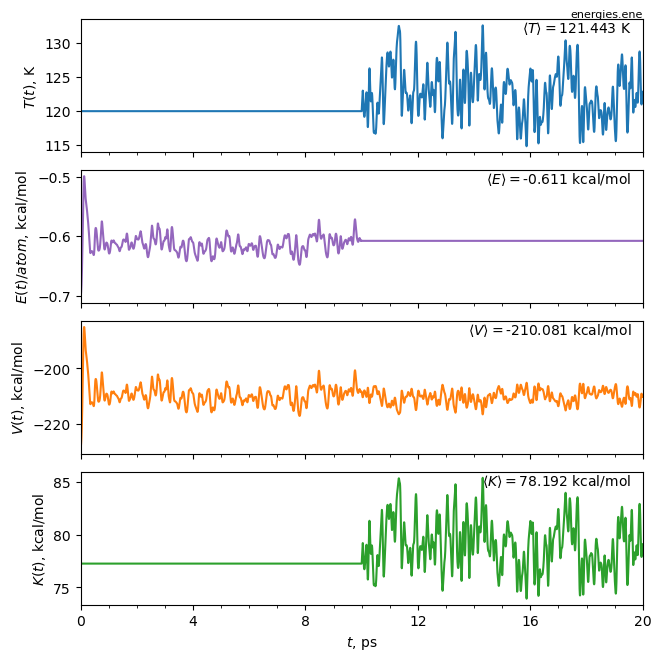

In [37]:
def plot_energies(file_namestem):
    energy_data = np.loadtxt(f'{file_namestem}energies.ene')
    print(energy_data[-1, 4])
    fig, ax = plt.subplots(4, 1, figsize=(6.5, 6.5), layout='constrained', sharex=True, gridspec_kw={'hspace':0.08})

    # Temperature
    ax[0].plot(energy_data[:,0], energy_data[:,5], color='tab:blue')
    ax[0].annotate(r'$\langle T \rangle = $'+f'{np.mean(energy_data[1002:,5]):.3f} K', (0.98,0.9), xycoords='axes fraction', ha='right')
    ax[0].set_xlim(0, energy_data[:,0].max())
    ax[0].set_ylabel(r'$T(t)$'+', K')
    ax[0].tick_params(axis='x', labelbottom=False)

    # Total Energy
    ax[1].plot(energy_data[:,0], energy_data[:,2], color='tab:purple')
    ax[1].annotate(r'$\langle E \rangle = $'+f'{np.mean(energy_data[1002:,2]):.3f} kcal/mol', (0.98,0.9), xycoords='axes fraction', ha='right')
    ax[1].set_ylabel(r'$E(t)/atom$'+', kcal/mol')
    ax[1].set_xlim(0, energy_data[:,0].max())
    ax[1].tick_params(axis='x', labelbottom=False)

    # Potential Energy
    ax[2].plot(energy_data[:,0], energy_data[:,4], color='tab:orange')
    ax[2].annotate(r'$\langle V \rangle = $'+f'{np.mean(energy_data[1002:,4]):.3f} kcal/mol', (0.98,0.9), xycoords='axes fraction', ha='right')
    ax[2].set_xlim(0, energy_data[:,0].max())
    ax[2].set_ylabel(r'$V(t)$'+', kcal/mol')
    ax[2].tick_params(axis='x', labelbottom=False)

    # Kinetic Energy
    ax[3].plot(energy_data[:,0], energy_data[:,3], color='tab:green')
    ax[3].annotate(r'$\langle K \rangle = $'+f'{np.mean(energy_data[1002:,3]):.3f} kcal/mol', (0.98,0.9), xycoords='axes fraction', ha='right')
    ax[3].set_xlim(0, energy_data[:,0].max())
    ax[3].set_xlabel(r'$t$'+', ps')
    ax[3].set_ylabel(r'$K(t)$'+', kcal/mol')

    # These will be applied to all axes because in plt.subplots we used sharex=True
    ax[3].xaxis.set_major_locator(MaxNLocator(6))
    ax[3].xaxis.set_minor_locator(AutoMinorLocator())

    ax[0].set_title(f'{file_namestem}energies.ene', loc="right", pad=1, fontsize=8)

    plt.show()
# plot_energies("solid_")
# plot_energies("liquid_")
plot_energies("")

### The Radial Distribution Function, $g(r)$ ###

The radial distribution function, $g(r)$, describes the structure of the system. To calculate $g(r)$ for a given particle you count the number of particles between $r$ and $r+dr$ away, $N_{r}$. Then, you calculate $g(r)$:

$$ g(r) = \frac{N_r}{\rho 4 \pi r^2 dr}. $$

In practice, this looks like creating a histogram around each particle and then averaging the particles' histogram bins.

In [38]:
@njit
def rdf(trajectory, box_length, nbins):
    '''
    Compute the radial distribution function

    Parameters
    ----------
    trajectory : numpy.ndarray(shape=(n_frames, n_particles, 3), dtype=float)
        The trajectory of unwrapped positions of the particles through the trajectory.
    box_length : float
        The length of the box, in angstroms.
    nbins : int
        The number of RDF bins

    Returns
    -------
    r_values : numpy.ndarray(ndim=1, size=box_length/(2*dr), dtype=float)
        The values of r corresponding to the values in g_r
    gr_values : numpy.ndarray(ndim=1, size=box_length/(2*dr), dtype=float)
        The radial distribution function
    '''
    rho = trajectory[0].shape[0]/(box_length**3) # number density of system
    dr = box_length/(2*nbins)
    r_values = np.arange(0, box_length/2, dr)[:-1]
    gr_values = np.zeros_like(r_values)
    for unwrapped_positions in trajectory:
        for i in range(unwrapped_positions.shape[0]-1):
            for j in range(i+1, unwrapped_positions.shape[0]):
                r = unwrapped_positions[i]-unwrapped_positions[j]
                r = r - (box_length*np.round(r/box_length)) # Periodic boundary conditions
                r = np.sqrt(np.sum(r**2)) # distance
                if r < box_length/2: # If less than max radius
                    ri = int(np.floor(r/dr)) # bin index
                    gr_values[ri] += 2
    
    vol = (4/3)*np.pi*((r_values+dr)**3-r_values**3) # volume between r and r+dr for each r
    nid = vol*rho # for case of ideal distribution of atoms
    gr_values = gr_values / (nid*trajectory.shape[0]*trajectory.shape[1])

    r_values = r_values + (dr/2)

    return r_values, gr_values

In [39]:
times, trajectory = readXYZ(f"unwrapped_positions.xyz", stage="production")
rs, grs = rdf(trajectory, 23.1, 1000)
np.savetxt("MD_rdf.dat", np.column_stack([rs, grs]), header="# col1: r, col2: g(r)")

# times, trajectory = readXYZ(f"liquid_unwrapped_positions.xyz", stage="production")
# rl, grl = rdf(trajectory, box_length*sigma, 1000)

<>:7: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\A'
/var/folders/d9/61wzb0q936n_p3z6f86d9qm40000gn/T/ipykernel_21642/3707306158.py:7: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel(f"r, $\AA$")


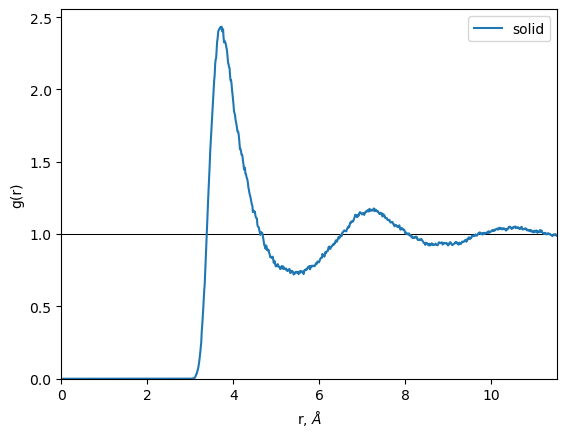

In [40]:
fig, ax = plt.subplots()
ax.axhline(1, color="k", linewidth=0.75)
ax.plot(rs, grs, color="tab:blue", label="solid")
# ax.plot(rl, grl, color="tab:green", label="liquid")
ax.set_ylim(0,np.max(grs)*1.05)
ax.set_xlim(0,np.max(rs))
ax.set_xlabel(f"r, $\AA$")
ax.set_ylabel("g(r)")
ax.legend()
plt.show()

In [21]:
energies = np.loadtxt("energies.ene")
energies[energies[1]==1]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 31001 but corresponding boolean dimension is 6

In [41]:
times, trajectory = readXYZ("2_unwrapped_positions.xyz", stage="production")
np.savetxt("starting_positions.dat", trajectory[-1])